# FMA: A Dataset For Music Analysis

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Baselines

* This notebook evalutates standard classifiers from scikit-learn on the provided features.
* Moreover, it evaluates Deep Learning models on both audio and spectrograms.

In [1]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
from keras.models import Sequential

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier


import utils
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.pipeline import make_pipeline


Using TensorFlow backend.
/Users/dtgo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/dtgo/anaconda3/lib/python3.6/site-packages/dotenv/main.py:24: UserWarning: Not loading  - it doesn't exist.
  warnings.warn("Not loading %s - it doesn't exist." % dotenv_path)


In [2]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks = utils.load('data/tracks.csv')
features = utils.load('data/features.csv')
echonest = utils.load('data/echonest.csv')
print(echonest.shape)

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

(13129, 249)


((106574, 52), (106574, 518), (13129, 249))

## Subset

In [5]:
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((25000, 52), (25000, 518))

In [6]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(MultiLabelBinarizer().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

19922 training examples, 2505 validation examples, 2573 testing examples
Top genres (35): [' ', '-', '/', 'B', 'C', 'E', 'F', 'H', 'I', 'J', 'L', 'O', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'g', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'x', 'y', 'z']
All genres (151): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 53, 58, 63, 64, 65, 66, 70, 71, 74, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 97, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 137, 138, 166, 167, 169, 171, 172, 174, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 311, 314, 322, 337, 359, 360, 361, 362, 374, 378, 400, 401, 404, 428, 439, 440, 441, 442, 443, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 651, 659, 695, 741, 763, 808, 810, 811, 906, 1032, 1060, 1193, 1235]


## 1 Multiple classifiers and feature sets

Todo:
* Cross-validation for hyper-parameters.
* Dimensionality reduction?

### 1.1 Pre-processing

In [7]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False):
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns].as_matrix()
    X_val = features.loc[val, columns].as_matrix()
    X_test = features.loc[test, columns].as_matrix()
    
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

In [8]:
columns = ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
             'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
             'spectral_rolloff', 'tonnetz', 'zcr']
    
features.loc[train, columns].shape
features.shape

(106574, 518)

### 1.2 Single genre

In [9]:
##### softmax regression ########
## loss function of softmax regression
def getLoss(w,x,y,lam):
    m = x.shape[0] #number of training example
    y_mat = oneHotIt(y)  #convert the interger class coding in to a one-hot representation
    scores = np.dot(x,w) #comput raw class scores given input and current weight
    prob = softmax(scores) #perform softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T, (y_mat - prob)) + lam*w #And compute the gradient for the loss
    
    return loss, grad

## unidimentional array of labels into a one-hot varient
def oneHotIt(Y):
    m = Y.shape[0]
    OHX = scipy.sparse.csr_matrix((np.ones(m),(Y,np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

## determine the probabilities and predictions for each class when given a set of input data:
def getProbsAndPreds(someX,w):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs, preds

##
def getAccuracy(someX,someY,w):
    prob, prede = getProbsAndPreds(someX,w)
    accuracy = sum(prede == someY)/(float(len(someY)))
    return accuracy

    



In [18]:
def test_classifiers_features(classifiers, feature_sets, multi_label=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())

#     X_train_all = np.empty([19922,1])

#     X_test_all = np.empty([2573,1])
#     for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):
#         y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)
#         #scores.loc[fset_name, 'dim'] = X_train.shape[1]
#         X_train_all = np.hstack((X_train_all, X_train))
#         X_test_all = np.hstack((X_test_all, X_test))     
#         ##clf_name = 'kNN'
#         ##clf = classifiers[clf_name]
#         ##for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):
#         ##t = time.process_time()
#         ##clf.fit(X_train, y_train)
#         ##score = clf.score(X_test, y_test)
#         ##scores.loc[fset_name, clf_name] = score
#         ##times.loc[fset_name, clf_name] = time.process_time() - t  
#     X_train_all = np.delete(X_train_all,[0],axis=1)
#     X_test_all = np.delete(X_test_all,[0],axis=1)
#     print(X_train_all.shape, X_test_all.shape)
#     #return scores, times
    
    columns = ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
             'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
             'spectral_rolloff', 'tonnetz', 'zcr']
    
    y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features, columns, multi_label=False, verbose=False);
    

    #print("x size, y size: ", X_train_all.shape, y_train.shape)
    model = SelectKBest(k=275)
    fit = model.fit(X_train, y_train)
    X_train = fit.transform(X_train)
    X_test = fit.transform(X_test)
    
    M = X_train.shape[0]/10
    X_learning = np.empty(10)
    Y_train_curve = np.empty(10)
    Y_test_curve = np.empty(10)
    for j in range(10):
        MJ = int(M*j)
        X_train_this = np.delete(X_train,np.s_[0:MJ],axis=0)
        Y_train_this = np.delete(y_train,np.s_[0:MJ],axis=0)
        

        
        w = np.zeros([X_train_this.shape[1], 16])   #len(np.unique(Y_train_this)=16
        lam = 1
        iterations = 5000
        learningRate = 1e-4
        losses = []
        
        
        for i in range(0,iterations):
            loss, grad = getLoss(w,X_train_this,Y_train_this,lam)
            losses.append(loss)
            w = w - (learningRate * grad)

            
        #print(loss)
        
        X_learning[j] = (10-j)*M
        Y_train_curve[j] = getAccuracy(X_train_this,Y_train_this,w)
        Y_test_curve[j] = getAccuracy(X_test,y_test,w)
        print('Training Accuracy:', Y_train_curve[j])
        print('Test Accuracy:', Y_test_curve[j])
      
    plt.plot(X_learning, Y_train_curve, linewidth = 2.0, color = 'red')
    plt.plot(X_learning, Y_test_curve, linewidth = 2.0, color = 'blue')
    plt.show()
    #print('Training Accuracy:', getAccuracy(X_train,y_train,w))
    #print('Test Accuracy:', getAccuracy(X_test,y_test,w))


def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])

shape:  (19922, 518) (19922,)
2.72712255201
Training Accuracy: 0.479670715792
Test Accuracy: 0.47260007773
shape:  (17930, 518) (17930,)
2.72705942451
Training Accuracy: 0.482208588957
Test Accuracy: 0.471822774971
shape:  (15938, 518) (15938,)
2.72656854697
Training Accuracy: 0.482933868741
Test Accuracy: 0.472211426351
shape:  (13946, 518) (13946,)
2.72629859806
Training Accuracy: 0.485730675462
Test Accuracy: 0.474154683249
shape:  (11954, 518) (11954,)
2.72631561022
Training Accuracy: 0.487870168981
Test Accuracy: 0.474931986009
shape:  (9961, 518) (9961,)
2.72590218012
Training Accuracy: 0.492219656661
Test Accuracy: 0.475709288768
shape:  (7969, 518) (7969,)
2.72544865504
Training Accuracy: 0.492784540093
Test Accuracy: 0.471822774971
shape:  (5977, 518) (5977,)
2.72425531267
Training Accuracy: 0.497574033796
Test Accuracy: 0.474543334629
shape:  (3985, 518) (3985,)
2.72301800337
Training Accuracy: 0.502885821832
Test Accuracy: 0.474931986009
shape:  (1993, 518) (1993,)
2.72654753076
Training Accuracy: 0.508278976417
Test Accuracy: 0.482316362223

In [8]:
classifiers = {
    'LR': LogisticRegression(),
}

feature_sets = {
}
for name in features.columns.levels[0]:
    feature_sets[name] = name
feature_sets.update({
    'mfcc/contrast': ['mfcc', 'spectral_contrast'],
    'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
    'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
    'all_non-echonest': list(features.columns.levels[0])
})
test_classifiers_features(classifiers, feature_sets)

#ipd.display(format_scores(scores))
#ipd.display(times.style.format('{:.4f}'))

KeyboardInterrupt: 

Softmax regression for all features
2.72712255201
Training Accuracy: 0.479670715792
Test Accuracy: 0.47260007773

Training Accuracy: 0.528711976709
Test Accuracy: 0.510299261562
Training Accuracy: 0.531622978249
Test Accuracy: 0.5134084726
Training Accuracy: 0.534320491906
Test Accuracy: 0.511465215702
Training Accuracy: 0.534848702137
Test Accuracy: 0.510299261562
Training Accuracy: 0.537309687134
Test Accuracy: 0.511465215702
Training Accuracy: 0.539303282803
Test Accuracy: 0.512242518461
Training Accuracy: 0.541849667461
Test Accuracy: 0.512242518461
Training Accuracy: 0.543751045675
Test Accuracy: 0.5134084726
Training Accuracy: 0.554579673777
Test Accuracy: 0.511465215702
Training Accuracy: 0.567486201706
Test Accuracy: 0.517294986397

In [19]:
feature_sets
features.columns.levels[0]

Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
       'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
       'spectral_rolloff', 'tonnetz', 'zcr'],
      dtype='object', name='feature')

牛油网络开始啦！

In [17]:
columns = ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
             'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
             'spectral_rolloff', 'tonnetz', 'zcr']
    
y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features, columns, multi_label=False, verbose=False);
print(X_train.shape)

(19922, 518)


In [18]:
### PCA
#X_train = PCA(n_components=518).fit_transform(X_train)
#X_test = PCA(n_components=518).fit_transform(X_test)
### feature selection

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
model = SelectKBest(k=300)
fit = model.fit(X_train, y_train)
X_train = fit.transform(X_train)
X_test = fit.transform(X_val)
y_test = y_val

#X_train = SelectKBest(k=200).fit_transform(X_train, y_train)
#X_test = SelectKBest(k=200).fit_transform(X_test, y_test)
#pipe = make_pipeline(
#    SelectKBest(k=200)
#)
#pipe.fit(X_train, y_train)
#X_test = pipe.predict(X_test)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19922, 518)
(19922,)
(2573, 518)
(2573,)
(19922, 300)
(19922,)
(2505, 300)
(2505,)


In [19]:
model = Sequential([
    Dense(100,input_dim=300),
    Activation('sigmoid'),
    Dense(33,input_dim=100),
    Activation('sigmoid'),
    Dense(16),
    Activation('softmax'),
])

# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Convert labels to categorical one-hot encoding
one_hot_labels = keras.utils.to_categorical(y_train, num_classes=16)

# Train the model, iterating on the data in batches of 32 samples
model.fit(X_train, one_hot_labels, epochs=20, batch_size=200)
ylabels = keras.utils.to_categorical(y_test, num_classes=16)
model.evaluate(X_test, ylabels)

Epoch 1/20
19922/19922 [==============================] - 1s 30us/step - loss: 1.8160 - acc: 0.4673
Epoch 2/20
19922/19922 [==============================] - 0s 21us/step - loss: 1.4566 - acc: 0.5445
Epoch 3/20
19922/19922 [==============================] - 0s 21us/step - loss: 1.3281 - acc: 0.6117
Epoch 4/20
19922/19922 [==============================] - 0s 16us/step - loss: 1.2515 - acc: 0.6319
Epoch 5/20
19922/19922 [==============================] - 0s 19us/step - loss: 1.1991 - acc: 0.6449
Epoch 6/20
19922/19922 [==============================] - 0s 16us/step - loss: 1.1606 - acc: 0.6530
Epoch 7/20
19922/19922 [==============================] - 0s 16us/step - loss: 1.1305 - acc: 0.6596
Epoch 8/20
19922/19922 [==============================] - 0s 16us/step - loss: 1.1055 - acc: 0.6642
Epoch 9/20
19922/19922 [==============================] - 0s 17us/step - loss: 1.0852 - acc: 0.6704
Epoch 10/20
19922/19922 [==============================] - 0s 16us/step - loss: 1.0667 - acc: 0.6735

[1.1062243672426113, 0.66027944111776449]

model = Sequential([
    Dense(320,input_dim=518),
    Activation('sigmoid'),
    Dense(32,input_dim=320),
    Activation('sigmoid'),
    Dense(16),
    Activation('softmax'),
])
0.8050
0.6129

67.03%

新的牛油网络！

In [ ]:
feature_sets = {
     'all': ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
           'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
           'spectral_rolloff', 'tonnetz', 'zcr']
    
y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)

In [181]:
X_train = PCA(n_components=250).fit_transform(X_train)
X_test = PCA(n_components=250).fit_transform(X_train)

ValueError: n_components=250 must be between 0 and n_features=2 with svd_solver='full'

(19922, 250)
(19922,)
(2573, 250)
(2573,)
Epoch 1/20
19922/19922 [==============================] - 1s 33us/step - loss: 2.0057 - acc: 0.3901
Epoch 2/20
19922/19922 [==============================] - 0s 15us/step - loss: 1.5376 - acc: 0.5310
Epoch 3/20
19922/19922 [==============================] - 0s 17us/step - loss: 1.3604 - acc: 0.5878
Epoch 4/20
19922/19922 [==============================] - 0s 14us/step - loss: 1.2622 - acc: 0.6333
Epoch 5/20
19922/19922 [==============================] - 0s 16us/step - loss: 1.1974 - acc: 0.6486
Epoch 6/20
19922/19922 [==============================] - 0s 19us/step - loss: 1.1525 - acc: 0.6562
Epoch 7/20
19922/19922 [==============================] - 0s 18us/step - loss: 1.1194 - acc: 0.6650
Epoch 8/20
19922/19922 [==============================] - 0s 18us/step - loss: 1.0932 - acc: 0.6700
Epoch 9/20
19922/19922 [==============================] - 0s 16us/step - loss: 1.0704 - acc: 0.6751
Epoch 10/20
19922/19922 [==============================] -

2573/2573 [==============================] - 0s 100us/step
Epoch 1/20
3985/3985 [==============================] - 1s 146us/step - loss: 2.7639 - acc: 0.0996
Epoch 2/20
3985/3985 [==============================] - 0s 13us/step - loss: 2.2739 - acc: 0.4118
Epoch 3/20
3985/3985 [==============================] - 0s 14us/step - loss: 2.0283 - acc: 0.4718
Epoch 4/20
3985/3985 [==============================] - 0s 15us/step - loss: 1.8589 - acc: 0.4853
Epoch 5/20
3985/3985 [==============================] - 0s 16us/step - loss: 1.7287 - acc: 0.4959
Epoch 6/20
3985/3985 [==============================] - 0s 17us/step - loss: 1.6261 - acc: 0.5046
Epoch 7/20
3985/3985 [==============================] - ETA: 0s - loss: 1.5504 - acc: 0.517 - 0s 17us/step - loss: 1.5462 - acc: 0.5189
Epoch 8/20
3985/3985 [==============================] - 0s 16us/step - loss: 1.4812 - acc: 0.5405
Epoch 9/20
3985/3985 [==============================] - 0s 16us/step - loss: 1.4271 - acc: 0.5644
Epoch 10/20
3985/398

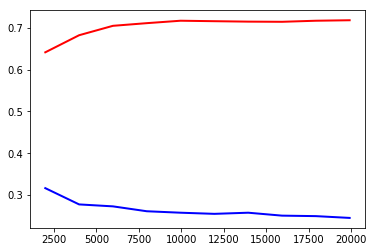

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

M = X_train.shape[0]/10
X_learning = np.empty(10)
Y_train_curve = np.empty(10)
Y_test_curve = np.empty(10)
for j in range(10):
    MJ = int(M*j)
    
    model = Sequential([
    Dense(100,input_dim=250),
    Activation('sigmoid'),
    Dense(32,input_dim=100),
    Activation('sigmoid'),
    Dense(16),
    Activation('softmax'),

    ])

# For a multi-class classification problem
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])



    
    
    X_train_this = np.delete(X_train,np.s_[0:MJ],axis=0)
    Y_train_this = np.delete(y_train,np.s_[0:MJ],axis=0)
    X_learning[j] = (10-j)*M
    
    one_hot_labels = keras.utils.to_categorical(Y_train_this, num_classes=16)
    trainingObj = model.fit(X_train_this, one_hot_labels, epochs=20, batch_size=200)
    Y_train_curve[j] = trainingObj.history['acc'][19]   
    ylabels = keras.utils.to_categorical(y_test, num_classes=16)
    testingObj = model.evaluate(X_test, ylabels)
    Y_test_curve[j] = testingObj[1]
    

plt.plot(X_learning, Y_train_curve, linewidth = 2.0, color = 'red')
plt.plot(X_learning, Y_test_curve, linewidth = 2.0, color = 'blue')
plt.show()


# # Generate dummy data
# data = X_train  # 19922,518
# labels = y_train # 19922,1

# # Convert labels to categorical one-hot encoding
# one_hot_labels = keras.utils.to_categorical(labels, num_classes=16)

# # Train the model, iterating on the data in batches of 32 samples
# a = model.fit(data, one_hot_labels, epochs=20, batch_size=200)



In [172]:
print(Y_train_curve)
print(Y_test_curve)

[ 0.79635579  0.79057446  0.7867361   0.78380897  0.77313033  0.77100692
  0.75969381  0.7579053   0.7455458   0.72754642]
[ 0.62883793  0.6195103   0.62767198  0.62456277  0.62223086  0.61251457
  0.62223086  0.60746211  0.60979401  0.57403809]


In [161]:
b = a.history['acc'][19]
#b[19]
print(b)

0.836311614629


In [163]:
ylabels = keras.utils.to_categorical(y_test, num_classes=16)
x = model.evaluate(X_test, ylabels)
print(x)

2573/2573 [==============================] - 0s 37us/step
[1.46771096395603, 0.60124368442666243]


In [164]:
x[1]

0.60124368442666243

### 1.3 Multiple genres

Todo:
* Ignore rare genres? Count them higher up in the genre tree? On the other hand it's not much tracks.

In [10]:
classifiers = {
    #LogisticRegression(),
    'LR': OneVsRestClassifier(LogisticRegression()),
    #'SVC': OneVsRestClassifier(SVC()),
    #'MLP': MLPClassifier(max_iter=700),
}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
    'mfcc': 'mfcc',
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
}

scores, times = test_classifiers_features(classifiers, feature_sets, multi_label=True)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))

KeyboardInterrupt: 

## 2 Deep learning on raw audio

Other architectures:
* [Learning Features of Music from Scratch (MusicNet)](https://arxiv.org/abs/1611.09827), John Thickstun, Zaid Harchaoui, Sham Kakade.

In [12]:
labels_onehot = MultiLabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

Load audio samples in parallel using `multiprocessing` so as to maximize CPU usage when decoding MP3s and making some optional pre-processing. There are multiple ways to load a waveform from a compressed MP3:
* librosa uses audioread in the backend which can use many native libraries, e.g. ffmpeg
    * resampling is very slow --> use `kaiser_fast`
    * does not work with multi-processing, for keras `fit_generator()`
* pydub is a high-level interface for audio modification, uses ffmpeg to load
    * store a temporary `.wav`
* directly pipe ffmpeg output
    * fastest method
* [pyAV](https://github.com/mikeboers/PyAV) may be a fastest alternative by linking to ffmpeg libraries

In [13]:
# Just be sure that everything is fine. Multiprocessing is tricky to debug.
utils.FfmpegLoader().load(utils.get_audio_path(AUDIO_DIR, 2))
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, utils.FfmpegLoader())
SampleLoader(train, batch_size=2).__next__()[0].shape

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [15]:
# Keras parameters.
NB_WORKER = len(os.sched_getaffinity(0))  # number of usables CPUs
params = {'pickle_safe': True, 'nb_worker': NB_WORKER, 'max_q_size': 10}

AttributeError: module 'os' has no attribute 'sched_getaffinity'

### 2.1 Fully connected neural network

* Two layers with 10 hiddens is no better than random, ~11%.

Optimize data loading to be CPU / GPU bound, not IO bound. Larger batches means reduced training time, so increase batch time until memory exhaustion. Number of workers and queue size have no influence on speed.

In [16]:
loader = utils.FfmpegLoader(sampling_rate=2000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
print('Dimensionality: {}'.format(loader.shape))

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(output_dim=1000, input_shape=loader.shape))
model.add(Activation("relu"))
model.add(Dense(output_dim=100))
model.add(Activation("relu"))
model.add(Dense(output_dim=labels_onehot.shape[1]))
model.add(Activation("softmax"))



optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=64), train.size, nb_epoch=2, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=64), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=64), test.size, **params)
#Y = model.predict_generator(SampleLoader(test, batch_size=64), test.size, **params);

loss

Dimensionality: (59953,)


/Users/dtgo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_shape=(59953,), units=1000)`
  
/Users/dtgo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=100)`
  # Remove the CWD from sys.path while we load stuff.
/Users/dtgo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=35)`
  if sys.path[0] == '':
/Users/dtgo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have c

Epoch 1/2


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/dtgo/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/dtgo/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dtgo/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 630, in data_generator_task
    generator_output = next(self._generator)
  File "/Users/dtgo/Stanford Document/courses/2017Fall/CS229/FinalProject/fma/utils.py", line 335, in __next__
    self.X[i] = self.loader.load(get_audio_path(audio_dir, tid))
  File "/Users/dtgo/Stanford Document/courses/2017Fall/CS229/FinalProject/fma/utils.py", line 232, in get_audio_path
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')
  File "/Users/dtgo/anaconda3/lib/python3.6/posixpath.py", line 78, in join
    a = os.fspath(a)
TypeError: expected str, bytes or os.PathLike object, not NoneType



StopIteration: 

### 2.2 Convolutional neural network

* Architecture: [End-to-end learning for music audio](http://www.mirlab.org/conference_papers/International_Conference/ICASSP%202014/papers/p7014-dieleman.pdf), Sander Dieleman, Benjamin Schrauwen.
* Missing: track segmentation and class averaging (majority voting)
* Compared with log-scaled mel-spectrograms instead of strided convolution as first layer.
* Larger net: http://benanne.github.io/2014/08/05/spotify-cnns.html

In [ ]:
loader = utils.FfmpegLoader(sampling_rate=16000)
#loader = utils.LibrosaLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((-1, 1), input_shape=loader.shape))
print(model.output_shape)

model.add(Conv1D(128, 512, subsample_length=512))
print(model.output_shape)
model.add(Activation("relu"))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

print(model.output_shape)
#model.add(Dropout(0.25))
model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
model.add(Activation("relu"))
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=10), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=10), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=10), test.size, **params)

loss

### 2.3 Recurrent neural network

## 3 Deep learning on extracted audio features

Look at:
* Pre-processing in Keras: https://github.com/keunwoochoi/kapre
* Convolutional Recurrent Neural Networks for Music Classification: https://github.com/keunwoochoi/icassp_2017
* Music Auto-Tagger: https://github.com/keunwoochoi/music-auto_tagging-keras
* Pre-processor: https://github.com/bmcfee/pumpp

### 3.1 ConvNet on MFCC

* Architecture: [Automatic Musical Pattern Feature Extraction Using Convolutional Neural Network](http://www.iaeng.org/publication/IMECS2010/IMECS2010_pp546-550.pdf), Tom LH. Li, Antoni B. Chan and Andy HW. Chun
* Missing: track segmentation and majority voting.
* Best seen: 17.6%

In [ ]:
class MfccLoader(utils.Loader):
    raw_loader = utils.FfmpegLoader(sampling_rate=22050)
    #shape = (13, 190)  # For segmented tracks.
    shape = (13, 2582)
    def load(self, filename):
        import librosa
        x = self.raw_loader.load(filename)
        # Each MFCC frame spans 23ms on the audio signal with 50% overlap with the adjacent frames.
        mfcc = librosa.feature.mfcc(x, sr=22050, n_mfcc=13, n_fft=512, hop_length=256)
        return mfcc

loader = MfccLoader()
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
loader.load(utils.get_audio_path(AUDIO_DIR, 2))[0].shape

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((*loader.shape, 1),  input_shape=loader.shape))
print(model.output_shape)

model.add(Conv2D(3, 13, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Conv2D(15, 1, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Conv2D(65, 1, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(1e-3)#lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=16), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=16), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=16), test.size, **params)
#Y = model.predict_generator(loader, test.size, pickle_safe=True, nb_worker=NB_WORKER, max_q_size=5)

loss